# NOJ WakeModel

[Try this yourself](https://colab.research.google.com/github/DTUWindEnergy/PyWake/blob/master/docs/notebooks/noj.ipynb) (requires google account)


In [0]:
%%capture
# Install PyWake if needed
try:
    import py_wake
except ModuleNotFoundError:
    !pip install py_wake


In [25]:
import numpy as np
import matplotlib.pyplot as plt

from py_wake.examples.data.hornsrev1 import V80, Hornsrev1Site, wt9_x, wt9_y
from py_wake.wake_models.noj import NOJ
windTurbines = V80()
wake_model = NOJ(windTurbines, k=0.1)

The `NOJ` is a subclass of the general `WakeModel` class, see documentation [here](https://topfarm.pages.windenergy.dtu.dk/PyWake/wake_models/WakeModel.html)

It implements the wake model of Niels Otto Jensen, described in "A note on wind generator interaction." (1983)

The implementation of `WakeModel` is highly vectorized and therefore suffixes are used to indicate the dimension of variables. The suffixes used in this context are:

- i: turbines ordered by id
- k: wind speeds
- l: wind directions

This means that `WS_ilk[0,1,2]` holds the wind speed at the first turbine for the second wind direction and third wind speed


`WakeModel` contains a method, [```calc_wake```](https://topfarm.pages.windenergy.dtu.dk/PyWake/wake_models/WakeModel.html#py_wake.wake_model.WakeModel.calc_wake), to calculate the effective wind speed, turbulence intensity (not implemented yet), power and thrust coefficient.

Let us try to calculate the effective wind speed for two V80 turbines separated by 200m in 10m/s and wind direction parallel to a line between the two turbines

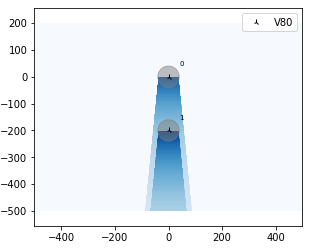

In [26]:
WS_eff_ilk, TI_eff_ilk, power_ilk, ct_ilk = wake_model.calc_wake(
    WS_ilk=np.array([[[10]],[[10]]]), # 10m/s at both turbines
    TI_ilk=np.array([[[.1]],[[.1]]]), # turbulence intensity (not used)
    dw_iil=np.array([[0, 200],
                     [-200, 0]])[:,:,np.newaxis], # 200m down stream separation
    hcw_iil=np.array([[0, 0],
                      [0, 0]])[:,:,np.newaxis], # wt aligned with wind -> zero cross wind distance
    dh_iil=np.array([[0, 0],
                     [0, 0]])[:,:,np.newaxis], # no hub height difference
    dw_order_indices_dl=np.array([[0, 1]]), # down stream order of turbines
    types_i=[0,0]) # both are turbine type 0

for i in [0,1]:
    print ('Turbine', i)
    print ('Effective wind speed %.2fm/s'%WS_eff_ilk[i, 0, 0])
    print ('Power production %.2fW'%power_ilk[i, 0, 0])
    print ('Thrust coefficient %f'%ct_ilk[i, 0, 0])
    print()


Turbine 0
Effective wind speed 10.00m/s
Power production 1341000.00W
Trust coefficient 0.793000

Turbine 1
Effective wind speed 7.58m/s
Power production 596326.74W
Trust coefficient 0.805578



To calculate this, `calc_wake`, uses two wake-model specific methods, `calc_deficit` and `calc_effective_WS`.

`calc_deficit` calculates the deficit:

In [27]:
deficit = wake_model.calc_deficit(
    WS_lk=np.array([[10]]), # wind speed at current turbine
    D_src_l=np.array([80]), # diameter of current turbine
    D_dst_jl=np.array([[80]]), # diameter of downstream turbine(s)
    dw_jl=np.array([[200]]), # down wind distance
    cw_jl=np.array([[0]]), # cross wind distance (both horizontal and vertical)
    ct_lk=np.array([[0.793000]])) # thrust coefficient
print (deficit[0,0,0])


2.422344326030697


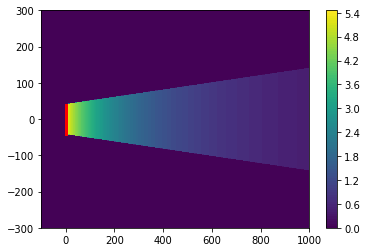

In [28]:
x = np.arange(-300,301,1.)
y = np.arange(-100,1001,1)
X,Y = np.meshgrid(x,y)
down_stream = Y>0
deficit_map=np.zeros_like(X)

deficit_map[down_stream] = wake_model.calc_deficit(
    WS_lk=np.array([[10]]), # wind speed at current turbine
    D_src_l=np.array([80]), # diameter of current turbine
    D_dst_jl=np.zeros_like(X)[down_stream][:,np.newaxis], # diameter of downstream turbine(s)
    dw_jl=Y[down_stream][:,np.newaxis], # down wind distance
    cw_jl=np.abs(X[down_stream])[:,np.newaxis], # cross wind distance (both horizontal and vertical)
    ct_lk=np.array([[0.793000]]))[:,0,0] # thrust coefficient

c = plt.contourf(Y,X,deficit_map,100)
plt.colorbar(c)
plt.plot([0,0],[-40,40],'r',lw=3)

while `calc_effective_WS` calculates the effective wind speed by subtracting the deficits from all upstream turbines from the local wind speed. For `NOJ` it subtracts the square root of the sum of squared deficits

In [29]:
wake_model.calc_effective_WS(
    WS_lk=np.array([[10]]), 
    deficit_jlk=deficit)

array([[7.57765567]])

Finally, `WakeModel`, contains the method `wake_map` to find the effective wind speed at arbitrary positions

In [30]:
#calculate the wake 200m down stream of a V80

wake_model.wake_map(
    WS_ilk=np.array([[[10]]]), # wind speed at turbine
    WS_eff_ilk=np.array([[[8.92340252]]]), 
    dw_ijl=np.array([[[200]]]), # one point 500m down stream 
    hcw_ijl=np.array([[[0]]]), # 0m cross wind distance 
    dh_ijl=np.array([[[0]]]), # at hub height
    ct_ilk=np.array([[[0.793000]]]), 
    types_i=[0], 
    WS_jlk=np.array([[[10]]]), # local wind speed at point
)

array([[[7.57765567]]])

For standard purposes, however, we do not call these methods manually. Instead we use the functions in `AEPCalculator`

**Calculate AEP**

AEP pr turbine: [9.00648938 9.17948543]


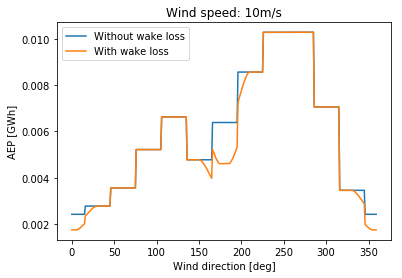

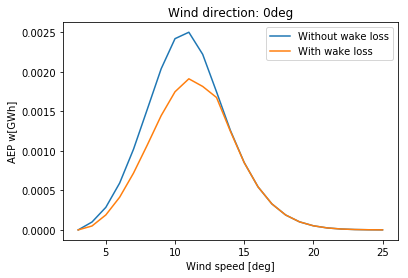

In [7]:
from py_wake.aep_calculator import AEPCalculator

site = Hornsrev1Site()
aep_calc = AEPCalculator(wake_model)

aep_gwh_ilk = aep_calc.calculate_AEP(x_i=[0,0], y_i=[0,-200])
aep_gwh_noloss_ilk = aep_calc.calculate_AEP_no_wake_loss(x_i=[0,0], y_i=[0,-200])


# AEP pr turbine
print ('AEP pr turbine:', aep_gwh_ilk.sum((1,2)))

# AEP pr wind direction
plt.plot(aep_gwh_noloss_ilk[:,:,7].sum(0), label='Without wake loss')
plt.plot(aep_gwh_ilk[:,:,7].sum(0), label='With wake loss')
plt.title('Wind speed: 10m/s')
plt.xlabel('Wind direction [deg]')
plt.ylabel('AEP [GWh]')
plt.legend()

# AEP pr wind speed
plt.figure()
plt.plot(site.default_ws, aep_gwh_noloss_ilk[:,0].sum(0), label='Without wake loss')
plt.plot(site.default_ws, aep_gwh_ilk[:,0].sum(0), label='With wake loss')
plt.title('Wind direction: 0deg')
plt.xlabel('Wind speed [deg]')
plt.ylabel('AEP [GWh]')
plt.legend()

**Wake map**

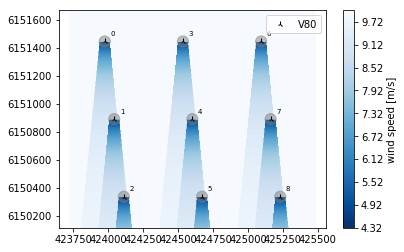

In [11]:
import matplotlib.pyplot as plt
x,y = wt9_x, wt9_y
aep_calc.plot_wake_map(wt_x=x, wt_y=y, wd=[0], ws=[10])
windTurbines.plot(x, y)
plt.show()


**Effective wind speed, power and thrust coefficient**

In [31]:
# wind from 0 deg(index=0) and 10m/s (index=7)

aep_calc.calculate_AEP(x_i=[0,0], y_i=[0,-200])
print ("Effective wind speed: wt0: %f\twt1: %f"%tuple(aep_calc.WS_eff_ilk[:,0,7])) 
print ("Power: wt0: %dW\twt1: %dW"%tuple(aep_calc.power_ilk[:,0,7])) 
print ("Thrust coefficient: wt0: %f\twt1: %f"%tuple(aep_calc.ct_ilk[:,0,7])) 
print ("Probability of ws=10m/s and wd=0deg: %f"%aep_calc.P_ilk[0,0,7])

Effective wind speed: wt0: 10.000000	wt1: 7.577656
Power: wt0: 1341000W	wt1: 596326W
Thrust coefficient: wt0: 0.793000	wt1: 0.805578
Probability of ws=10m/s and wd=0deg: 0.000103
